In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset,TensorDataset
from autoencoder import Autoencoder
import torchvision
from model2 import classification_model
import copy
import partition
from pca import PCADigitReducer
from autoencoder import reduce_dimensions
from training import train,test, train_fashion,test_fashion
from federated_learning import distribute_global_model, federated_averaging
from model4 import MultilayerPerceptron
import cluster

# Preprocessing

In [2]:
# Predefined stuff

n_epochs = 5
batch_size_train = 100
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
fashion_mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3204,))  
])

fashion_mnist_train_loader = DataLoader(
    datasets.FashionMNIST('/files/', train=True, download=True, transform=fashion_mnist_transform),
    batch_size=batch_size_train, shuffle=True
)

fashion_mnist_test_loader = DataLoader(
    datasets.FashionMNIST('/files/', train=False, download=True, transform=fashion_mnist_transform),
    batch_size=batch_size_test, shuffle=True
)

In [4]:
train_loader_pca = copy.copy(fashion_mnist_train_loader)
test_loader_pca = copy.copy(fashion_mnist_test_loader)

train_loader_auto = copy.copy(fashion_mnist_train_loader)
test_loader_auto = copy.copy(fashion_mnist_test_loader)

In [5]:
class CustomTensorDataset(TensorDataset):
    def __init__(self, *tensors):
        super().__init__(*tensors)
        self.data = tensors[0]
        self.targets = tensors[1] 

# Pca

In [11]:
train_data = []
train_labels = []
for data, labels in train_loader_pca:
    train_data.append(data.view(data.size(0), -1))  
    train_labels.append(labels)
train_data = torch.cat(train_data, dim=0)  
train_labels = torch.cat(train_labels, dim=0)

train_data_np = train_data.numpy()

pca = PCADigitReducer(100)
train_data_reduced = pca.fit_transform(train_data_np)  

train_data_reconstructed_np = pca.inverse_transform(train_data_reduced) 
train_data_reconstructed = torch.tensor(train_data_reconstructed_np, dtype=torch.float32)

train_data_reconstructed = train_data_reconstructed.view(-1, 1, 28, 28)

train_data_reconstructed = (train_data_reconstructed - 0.2860) / 0.3204

batch_size_train = train_loader_pca.batch_size
train_dataset_pca = CustomTensorDataset(train_data_reconstructed, train_labels)
train_loader_reduced_pca = DataLoader(train_dataset_pca, batch_size=batch_size_train, shuffle=True)

# Autoencoder

In [12]:
# Autoencoder
latent_dim = 100  
autoencoder = Autoencoder(latent_dim=latent_dim)
auto_criterion = nn.MSELoss()
auto_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
auto_num_epochs = 5
for epoch in range(auto_num_epochs): 
    for images, _ in train_loader_auto:
        auto_optimizer.zero_grad()
        reconstructed = autoencoder(images)
        loss = auto_criterion(reconstructed, images)  
        loss.backward()
        auto_optimizer.step()
        
    print(f"Epoch [{epoch+1}/5], Loss: {loss.item()}")

Epoch [1/5], Loss: 0.6598843336105347
Epoch [2/5], Loss: 0.6293150186538696
Epoch [3/5], Loss: 0.6253346800804138
Epoch [4/5], Loss: 0.5940108895301819
Epoch [5/5], Loss: 0.6230719089508057


In [13]:
autoencoder.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_features, labels = reduce_dimensions(train_loader_auto, autoencoder.encoder, device)
latent_features = latent_features.detach()

reconstructed_images = autoencoder.decoder(latent_features.to(device))  
reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)

# Experiment

In [14]:
alpha = 0.5
num_clients = 10
num_clusters = [2, 4, 6, 8, 10]
results = {"classic": {}, "pca": {}, "autoencoder": {}}
clusteredResults = {"classic": {}, "pca": {}, "autoencoder": {}}

# Classic

In [15]:
trainingset = fashion_mnist_train_loader.dataset
trial_model_strong = MultilayerPerceptron()
global_model_classic_strong = MultilayerPerceptron()
rounds_classic = 4

In [16]:

partitioned_data_classic = partition.balanced_dirichlet_partition(
    trainingset, partitions_number=num_clients, alpha=alpha)

classic_client_loaders = [
    DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_classic.values()
]

local_models_classic_strong = [copy.deepcopy(global_model_classic_strong) for _ in range(num_clients)]


optimizer = optim.SGD(trial_model_strong.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []

for epoch in range(1, n_epochs + 1):  
    train_fashion(epoch, trial_model_strong, fashion_mnist_train_loader, optimizer, log_interval, train_losses, train_counter)



test_losses_classic_strong = []
test_fashion(trial_model_strong,fashion_mnist_train_loader,test_losses_classic_strong)


for round_idx in range(rounds_classic):
    
    print(f"Round {round_idx + 1}/{rounds_classic}")

    local_weights_classic = []
    for client_idx, client_model in enumerate(local_models_classic_strong):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                      momentum=momentum)

        train_losses = []
        train_counter = []

        for epoch in range(1, n_epochs + 1):  
            train_fashion(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_classic.append(client_weights)
        

    global_weights_classic = federated_averaging(local_weights_classic)


    distribute_global_model(global_weights_classic,local_models_classic_strong,single=False)

    distribute_global_model(global_weights_classic,global_model_classic_strong,single=True)
    test_losses = []
    test_fashion(global_model_classic_strong,fashion_mnist_test_loader,test_losses)

    test_accuracies_classic = []
    correct = 0
    with torch.no_grad():
        for data, target in fashion_mnist_test_loader:
            data = data.view(data.shape[0], -1)
            output = global_model_classic_strong(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(fashion_mnist_test_loader.dataset)
    test_accuracies_classic.append(accuracy)

    results["classic"]["NoCluster"] = {"losses": [], "accuracy": []}

    results["classic"]["NoCluster"]["losses"].extend(test_losses)
    results["classic"]["NoCluster"]["accuracy"].extend(test_accuracies_classic)

    ######################
for num_cluster in num_clusters:
    import cluster
    cluster = cluster.Cluster(num_clusters=num_cluster)
    
    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_classic, targets, num_classes)
    
    partitioned_data_classic_clustered = clustered_data

    classic_client_loaders_clustered = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic_clustered.values()
    ]

    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")

        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic_strong[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
    
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)
            
    
        global_weights_classic = federated_averaging(local_weights_classic)
    
    
        distribute_global_model(global_weights_classic,local_models_classic_strong,single=False)
    
        distribute_global_model(global_weights_classic,global_model_classic_strong,single=True)
        test_losses = []
        test_fashion(global_model_classic_strong,fashion_mnist_test_loader,test_losses)

        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in fashion_mnist_test_loader:
                data = data.view(data.shape[0], -1)
                output = global_model_classic_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(fashion_mnist_test_loader.dataset)
        test_accuracies_classic.append(accuracy)

        if num_cluster not in clusteredResults["classic"]:
            clusteredResults["classic"][num_cluster] = {"losses": [], "accuracy": []}

        clusteredResults["classic"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["classic"][num_cluster]["accuracy"].extend(test_accuracies_classic)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.324810
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.199836
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.106051
Train Epoch: 1 [3000/60000 (5%)]	Loss: 1.900947
Train Epoch: 1 [4000/60000 (7%)]	Loss: 1.799925
Train Epoch: 1 [5000/60000 (8%)]	Loss: 1.511707
Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.348910
Train Epoch: 1 [7000/60000 (12%)]	Loss: 1.207755
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.161974
Train Epoch: 1 [9000/60000 (15%)]	Loss: 1.016412
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.945645
Train Epoch: 1 [11000/60000 (18%)]	Loss: 0.906458
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.855002
Train Epoch: 1 [13000/60000 (22%)]	Loss: 0.901501
Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.704619
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.864728
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.889839
Train Epoch: 1 [17000/60000 (28%)]	Loss: 0.847664
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.694646
Train Epoch: 1 [19000/60000 (32%)]	Loss: 0.868231
Train Epoch: 1 [200

C:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.3693, Accuracy: 52129/60000 (87%)

Round 1/4
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 2.299964
Train Epoch: 1 [1000/2540 (38%)]	Loss: 1.965513
Train Epoch: 1 [2000/2540 (77%)]	Loss: 1.761632
Train Epoch: 2 [0/2540 (0%)]	Loss: 1.626960
Train Epoch: 2 [1000/2540 (38%)]	Loss: 1.439416
Train Epoch: 2 [2000/2540 (77%)]	Loss: 1.407890
Train Epoch: 3 [0/2540 (0%)]	Loss: 1.182385
Train Epoch: 3 [1000/2540 (38%)]	Loss: 1.140931
Train Epoch: 3 [2000/2540 (77%)]	Loss: 1.201632
Train Epoch: 4 [0/2540 (0%)]	Loss: 1.152443
Train Epoch: 4 [1000/2540 (38%)]	Loss: 0.998125
Train Epoch: 4 [2000/2540 (77%)]	Loss: 0.936935
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.898230
Train Epoch: 5 [1000/2540 (38%)]	Loss: 0.826114
Train Epoch: 5 [2000/2540 (77%)]	Loss: 0.799782
Training client 2
Train Epoch: 1 [0/7342 (0%)]	Loss: 2.275290
Train Epoch: 1 [1000/7342 (14%)]	Loss: 1.398348
Train Epoch: 1 [2000/7342 (27%)]	Loss: 0.761844
Train Epoch: 1 [3000/7342 (41%)]	Loss: 0.674585
Train E

In [17]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.5188619812011719], 'accuracy': [80.19]}}, 'pca': {}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {2: {'losses': [0.6111913330078125, 0.5729868041992188, 0.5778576416015625, 0.5886122863769532], 'accuracy': [77.31, 78.64, 78.81, 78.37]}, 4: {'losses': [0.5569269927978515, 0.5164715148925781, 0.5319765411376953, 0.5280328765869141], 'accuracy': [79.38, 80.76, 80.22, 80.34]}, 6: {'losses': [0.4632906616210937, 0.4644641296386719, 0.4652772644042969, 0.44572009887695313], 'accuracy': [82.79, 82.6, 82.67, 83.38]}, 8: {'losses': [0.4280053955078125, 0.4304277587890625, 0.41870563354492185, 0.41287210998535157], 'accuracy': [84.37, 84.18, 84.51, 85.12]}, 10: {'losses': [0.4158003601074219, 0.4127583312988281, 0.4012933013916016, 0.39449208984375], 'accuracy': [84.9, 84.82, 85.3, 85.84]}}, 'pca': {}, 'autoencoder': {}}


## PCA

In [18]:
trainingset_pca = train_loader_reduced_pca.dataset
trial_model_pca_strong = MultilayerPerceptron()
global_model_pca_strong = MultilayerPerceptron()

In [19]:

partitioned_data_pca = partition.balanced_dirichlet_partition(trainingset_pca, partitions_number=num_clients, alpha=alpha)
pca_client_loaders = [
    DataLoader(Subset(trainingset_pca, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_pca.values()
]

local_models_pca_strong = [copy.deepcopy(global_model_pca_strong) for _ in range(num_clients)]

# Pca strong
optimizer = optim.SGD(trial_model_pca_strong.parameters(), lr=learning_rate,
                  momentum=momentum)

train_losses = []
train_counter = []

for epoch in range(1, n_epochs + 1):  
    train_fashion(epoch, trial_model_pca_strong, train_loader_reduced_pca, optimizer, log_interval, train_losses, train_counter)



test_losses_pca_strong = []
test_fashion(trial_model_pca_strong,train_loader_reduced_pca,test_losses_pca_strong)

rounds_pca = 4
for round_idx in range(rounds_pca):
    
    print(f"Round {round_idx + 1}/{rounds_pca}")

    local_weights_pca = []
    for client_idx, client_model in enumerate(local_models_pca_strong):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                      momentum=momentum)

        train_losses = []
        train_counter = []


        for epoch in range(1, n_epochs + 1):  
            train_fashion(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_pca.append(client_weights)
        

    global_weights_pca = federated_averaging(local_weights_pca)

    distribute_global_model(global_weights_pca,local_models_pca_strong,single=False)

    distribute_global_model(global_weights_pca,global_model_pca_strong,single=True)
    test_losses = []
    test_fashion(global_model_pca_strong,test_loader_pca,test_losses)

    test_accuracies_classic = []
    correct = 0
    with torch.no_grad():
        for data, target in test_loader_pca:
            data = data.view(data.shape[0], -1)
            output = global_model_pca_strong(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader_pca.dataset)
    test_accuracies_classic.append(accuracy)

    # Save results for non-clustered classic
    results["pca"]["NoCluster"] = {"losses": [], "accuracy": []}

    results["pca"]["NoCluster"]["losses"].extend(test_losses)
    results["pca"]["NoCluster"]["accuracy"].extend(test_accuracies_classic)

    ######################
for num_cluster in num_clusters:
    import cluster
    cluster = cluster.Cluster(num_clusters=num_cluster)
    
    targets = trainingset_pca.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_pca, targets, num_classes)
    
    partitioned_data_pca_clustered = clustered_data

    pca_client_loaders_clustered = [
        DataLoader(Subset(trainingset_pca, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_pca_clustered.values()
    ]

    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")

        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca_strong[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
    
            train_losses = []
            train_counter = []
    
    
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
            
    
        global_weights_pca = federated_averaging(local_weights_pca)
    
        distribute_global_model(global_weights_pca,local_models_pca_strong,single=False)
    
        distribute_global_model(global_weights_pca,global_model_pca_strong,single=True)
        test_losses = []
        test_fashion(global_model_pca_strong,test_loader_pca,test_losses)
    
        test_accuracies_pca = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_pca:
                data = data.view(data.shape[0], -1)
                output = global_model_pca_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_pca.dataset)
        test_accuracies_classic.append(accuracy)

        # Save results for clustered classic
        if num_cluster not in clusteredResults["pca"]:
            clusteredResults["pca"][num_cluster] = {"losses": [], "accuracy": []}

        clusteredResults["pca"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["pca"][num_cluster]["accuracy"].extend(test_accuracies_classic)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.345260
Train Epoch: 1 [1000/60000 (2%)]	Loss: 1.492300
Train Epoch: 1 [2000/60000 (3%)]	Loss: 1.183899
Train Epoch: 1 [3000/60000 (5%)]	Loss: 0.799436
Train Epoch: 1 [4000/60000 (7%)]	Loss: 0.870424
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.633455
Train Epoch: 1 [6000/60000 (10%)]	Loss: 0.764364
Train Epoch: 1 [7000/60000 (12%)]	Loss: 0.744924
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.734871
Train Epoch: 1 [9000/60000 (15%)]	Loss: 0.583149
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.732077
Train Epoch: 1 [11000/60000 (18%)]	Loss: 0.685209
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.541247
Train Epoch: 1 [13000/60000 (22%)]	Loss: 0.564458
Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.517843
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.475491
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.651481
Train Epoch: 1 [17000/60000 (28%)]	Loss: 0.735209
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.700579
Train Epoch: 1 [19000/60000 (32%)]	Loss: 0.563179
Train Epoch: 1 [200

In [20]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.5188619812011719], 'accuracy': [80.19]}}, 'pca': {'NoCluster': {'losses': [0.9590497436523437], 'accuracy': [82.92]}}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {2: {'losses': [0.6111913330078125, 0.5729868041992188, 0.5778576416015625, 0.5886122863769532], 'accuracy': [77.31, 78.64, 78.81, 78.37]}, 4: {'losses': [0.5569269927978515, 0.5164715148925781, 0.5319765411376953, 0.5280328765869141], 'accuracy': [79.38, 80.76, 80.22, 80.34]}, 6: {'losses': [0.4632906616210937, 0.4644641296386719, 0.4652772644042969, 0.44572009887695313], 'accuracy': [82.79, 82.6, 82.67, 83.38]}, 8: {'losses': [0.4280053955078125, 0.4304277587890625, 0.41870563354492185, 0.41287210998535157], 'accuracy': [84.37, 84.18, 84.51, 85.12]}, 10: {'losses': [0.4158003601074219, 0.4127583312988281, 0.4012933013916016, 0.39449208984375], 'accuracy': [84.9, 84.82, 85.3, 85.84]}}, 'pca': {2: {'losses': [0.9848575317382813, 0.95813520507

## Autoencoder

In [21]:
# Autoencoder
trainingset_auto = reduced_train_loader_auto.dataset
trial_model_auto_strong = MultilayerPerceptron()
global_model_auto_strong = MultilayerPerceptron()

In [23]:

partitioned_data_auto = partition.balanced_dirichlet_partition(trainingset_auto, partitions_number=num_clients, alpha=alpha)
auto_client_loaders = [
    DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_auto.values()
]

local_model_autoencoder_strong = [copy.deepcopy(global_model_auto_strong) for _ in range(num_clients)]

optimizer = optim.SGD(trial_model_auto_strong.parameters(), lr=learning_rate, momentum=momentum)

train_losses = []
train_counter = []

for epoch in range(1, n_epochs + 1):  
    train_fashion(epoch, trial_model_auto_strong, reduced_train_loader_auto, optimizer, log_interval, train_losses, train_counter)

test_losses_auto_strong = []
test_fashion(trial_model_auto_strong, reduced_train_loader_auto, test_losses_auto_strong)

rounds_auto = 4
for round_idx in range(rounds_auto):
    print(f"Round {round_idx + 1}/{rounds_auto}")
    
    local_weights_auto = []
    for client_idx, client_model in enumerate(local_model_autoencoder_strong):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
        
        train_losses = []
        train_counter = []
    
        for epoch in range(1, n_epochs + 1):  
            train_fashion(epoch, client_model, auto_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_auto.append(client_weights)
    
    global_weights_auto = federated_averaging(local_weights_auto)
    
    distribute_global_model(global_weights_auto, local_model_autoencoder_strong, single=False)
    distribute_global_model(global_weights_auto, global_model_auto_strong, single=True)
    
    test_losses = []
    test_fashion(global_model_auto_strong, test_loader_auto, test_losses)
    
    test_accuracies_classic = []
    correct = 0
    with torch.no_grad():
        for data, target in test_loader_auto:
            data = data.view(data.shape[0], -1)
            output = global_model_auto_strong(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader_auto.dataset)
    test_accuracies_classic.append(accuracy)
    
    # Save results for non-clustered classic
    results["autoencoder"]["NoCluster"] = {"losses": [], "accuracy": []}
    
    results["autoencoder"]["NoCluster"]["losses"].extend(test_losses)
    results["autoencoder"]["NoCluster"]["accuracy"].extend(test_accuracies_classic)

    ######################
    # Clustering process
for num_cluster in num_clusters:
    import cluster
    cluster = cluster.Cluster(num_clusters=num_cluster)
    
    targets = trainingset_auto.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_auto, targets, num_classes)
    
    partitioned_data_auto_clustered = clustered_data
    
    auto_client_loaders_clustered = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto_clustered.values()
    ]
    
    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")
        
        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder_strong[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []
        
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, auto_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
        
        global_weights_auto = federated_averaging(local_weights_auto)
        
        distribute_global_model(global_weights_auto, local_model_autoencoder_strong, single=False)
        distribute_global_model(global_weights_auto, global_model_auto_strong, single=True)
        
        test_losses = []
        test_fashion(global_model_auto_strong, test_loader_auto, test_losses)
        
        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_auto:
                data = data.view(data.shape[0], -1)
                output = global_model_auto_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_auto.dataset)
        test_accuracies_classic.append(accuracy)
        
        # Save results for clustered classic
        if num_cluster not in clusteredResults["autoencoder"]:
            clusteredResults["autoencoder"][num_cluster] = {"losses": [], "accuracy": []}

        clusteredResults["autoencoder"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["autoencoder"][num_cluster]["accuracy"].extend(test_accuracies_classic)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311788
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.297354
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.281559
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.260314
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.218559
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.193289
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.171206
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.116008
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.084164
Train Epoch: 1 [9000/60000 (15%)]	Loss: 1.963554
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.980799
Train Epoch: 1 [11000/60000 (18%)]	Loss: 1.847897
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.837845
Train Epoch: 1 [13000/60000 (22%)]	Loss: 1.744823
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.735857
Train Epoch: 1 [15000/60000 (25%)]	Loss: 1.559035
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.543303
Train Epoch: 1 [17000/60000 (28%)]	Loss: 1.371148
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.232727
Train Epoch: 1 [19000/60000 (32%)]	Loss: 1.291346
Train Epoch: 1 [200

In [24]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.5188619812011719], 'accuracy': [80.19]}}, 'pca': {'NoCluster': {'losses': [0.9590497436523437], 'accuracy': [82.92]}}, 'autoencoder': {'NoCluster': {'losses': [0.9626321166992188], 'accuracy': [69.05]}}}
Final Results (Clustered): {'classic': {2: {'losses': [0.6111913330078125, 0.5729868041992188, 0.5778576416015625, 0.5886122863769532], 'accuracy': [77.31, 78.64, 78.81, 78.37]}, 4: {'losses': [0.5569269927978515, 0.5164715148925781, 0.5319765411376953, 0.5280328765869141], 'accuracy': [79.38, 80.76, 80.22, 80.34]}, 6: {'losses': [0.4632906616210937, 0.4644641296386719, 0.4652772644042969, 0.44572009887695313], 'accuracy': [82.79, 82.6, 82.67, 83.38]}, 8: {'losses': [0.4280053955078125, 0.4304277587890625, 0.41870563354492185, 0.41287210998535157], 'accuracy': [84.37, 84.18, 84.51, 85.12]}, 10: {'losses': [0.4158003601074219, 0.4127583312988281, 0.4012933013916016, 0.39449208984375], 'accuracy': [84.9, 84.82, 85.3, 

# Plot


Non-Clustered Results:
classic:
  Average Loss: {'NoCluster': 0.5188619812011719}
  Average Accuracy: {'NoCluster': 80.19}
pca:
  Average Loss: {'NoCluster': 0.9590497436523437}
  Average Accuracy: {'NoCluster': 82.92}
autoencoder:
  Average Loss: {'NoCluster': 0.9626321166992188}
  Average Accuracy: {'NoCluster': 69.05}


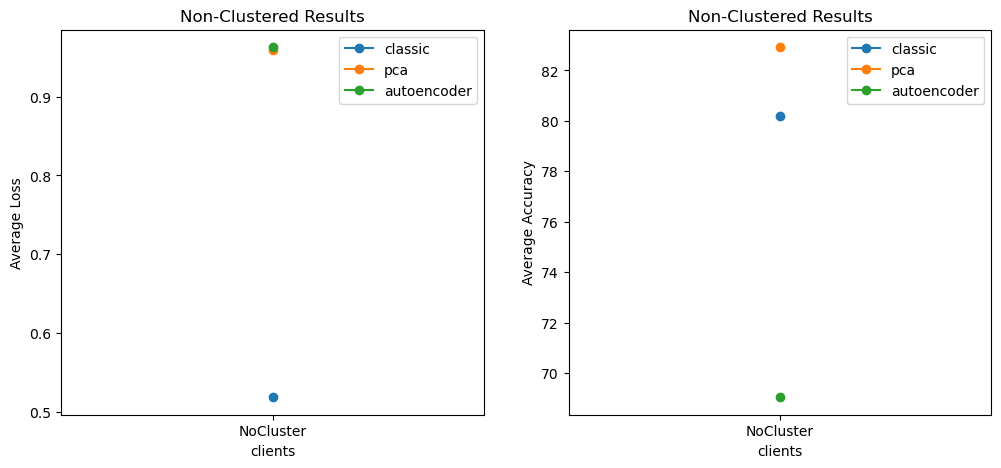


Clustered Results:
classic:
  Average Loss: {2: 0.5876620162963867, 4: 0.5333519813537598, 6: 0.4596880386352539, 8: 0.42250272445678716, 10: 0.4060860206604004}
  Average Accuracy: {2: 78.2825, 4: 80.175, 6: 82.86, 8: 84.545, 10: 85.215}
pca:
  Average Loss: {2: 0.9559410125732423, 4: 0.8798453475952148, 6: 0.8185487991333007, 8: 0.7789660507202149, 10: 0.7342041290283202}
  Average Accuracy: {2: 80.10428571428572, 4: 80.40933333333334, 6: 81.37695652173912, 8: 82.3624193548387, 10: 83.10397435897436}
autoencoder:
  Average Loss: {2: 0.8560549774169921, 4: 0.9068865783691407, 6: 0.9014146392822266, 8: 1.0045414611816406, 10: 1.0739033905029296}
  Average Accuracy: {2: 75.67750000000001, 4: 76.125, 6: 76.6575, 8: 75.21000000000001, 10: 74.39}


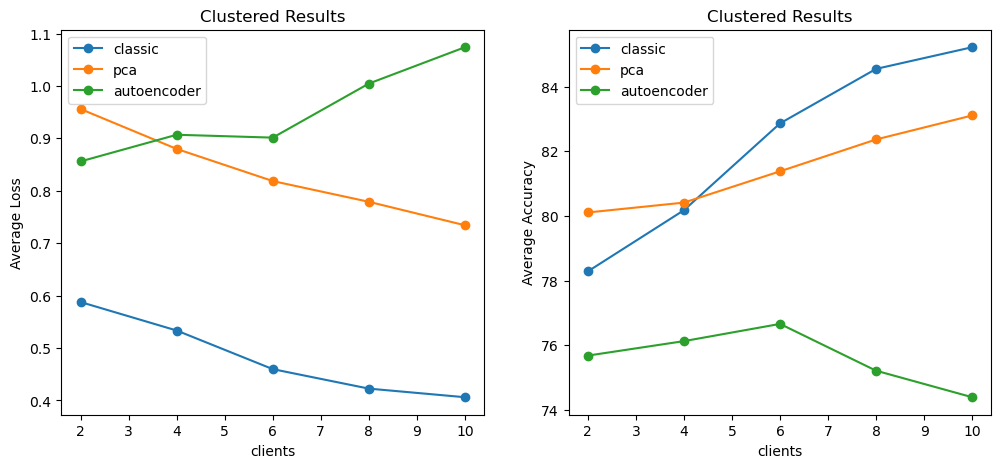

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def compute_avg(metrics):
    avg_loss = {alpha: np.mean(data['losses']) for alpha, data in metrics.items()}
    avg_accuracy = {alpha: np.mean(data['accuracy']) for alpha, data in metrics.items()}
    return avg_loss, avg_accuracy

def print_results(results, title):
    print(f"\n{title}:")
    for method in results.keys():
        avg_loss, avg_accuracy = compute_avg(results[method])
        print(f"{method}:")
        print("  Average Loss:", avg_loss)
        print("  Average Accuracy:", avg_accuracy)

def plot_results(results, title, filename):
    plt.figure(figsize=(12, 5))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    for method in results.keys():
        avg_loss, _ = compute_avg(results[method])
        plt.plot(avg_loss.keys(), avg_loss.values(), marker='o', label=method)
    plt.xlabel('clients')
    plt.ylabel('Average Loss')
    plt.title(f'{title}')
    plt.legend()
    
    # Accuracy Plot
    plt.subplot(1, 2, 2)
    for method in results.keys():
        _, avg_accuracy = compute_avg(results[method])
        plt.plot(avg_accuracy.keys(), avg_accuracy.values(), marker='o', label=method)
    plt.xlabel('clients')
    plt.ylabel('Average Accuracy')
    plt.title(f'{title}')
    plt.legend()
    plt.show()


print_results(results, "Non-Clustered Results")
plot_results(results, "Non-Clustered Results", "non_clustered_results.png")
print_results(clusteredResults, "Clustered Results")
plot_results(clusteredResults, "Clustered Results", "clustered_results.png")